# 1. Web scraping and analysis


The task is focused on scraping and collecting customer feedback and reviewing data from a website called Skytrax and analysing 

the data to present uncover insights.

In [4]:
import requests
from bs4 import BeautifulSoup
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud 

In [ ]:
base_url = "https://www.airlinequality.com/airline-reviews/british-airways"
pages = 10 #10
page_size = 100 #100

reviews = []
aircraft = []
seat_type = []
route = []
recommended = []
df = pd.DataFrame()


for i in range(1, pages + 1):
    
    rating = []
    category = []

    print(f"Scraping page {i}")
    
    # Create URL to collect links from paginated data
    url = f"{base_url}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}"

    # Collect HTML data from this page
    response = requests.get(url)

    # Parse content
    content = response.content
    parsed_content = BeautifulSoup(content, 'html.parser')
    for para in parsed_content.find_all("div", {"class": "text_content"}):
        reviews.append(para.get_text())
        
    for para2 in parsed_content.find_all("div", {"class" : "review-stats"}):
        for para3 in para2.find_all('td',{'class' : 'review-value'}):
            rating.append(para3.get_text())
        recomend = rating[-1]
        rating = rating[:-1]
        
        for para4 in para2.find_all('td',{'class' : 'review-rating-stars stars'}):
            para5 = len(para4.find_all('span', {'class' : 'star fill'}))
            rating.append(para5)
        rating.append(recomend)
        #print(rating)
        
        for para6 in para2.find_all('td',{'class' : 'review-rating-header'}):
            category.append(para6.get_text())
            
        #print(category)
        # Create the records from both list, using zip and dict calls.

        # Build the dataframe from the dictionary.
        data_dict = pd.DataFrame([rating], columns=category)
        df = df.append(data_dict, ignore_index=True).reset_index(drop=True)
        #print(df)
        rating = []
        category = []
        
    print(f"   ---> {len(reviews)} total reviews")

df["reviews"] = (reviews)

In [16]:
df.sample(5)

,Type Of Traveller,Seat Type,Route,Date Flown,Seat Comfort,Cabin Staff Service,Ground Service,Value For Money,Recommended,Food & Beverages,Inflight Entertainment,Wifi & Connectivity,Aircraft,reviews
470,Couple Leisure,Business Class,Edinburgh to Barbados via Gatwick,December 2019,5.0,5.0,5.0,5,yes,5.0,5.0,NaN,NaN,✅ Trip Verified | My husband and I had a wond...
555,Business,Business Class,Gatwick to Alicante,September 2019,5.0,5.0,2.0,5,yes,5.0,5.0,NaN,A320,Not Verified | Gatwick to Alicante. On my out...
467,Solo Leisure,Economy Class,Cape Town to Brussels via London,December 2019,3.0,5.0,4.0,4,yes,4.0,3.0,3.0,NaN,Not Verified | I recently flew from Cape Town...
625,Family Leisure,Economy Class,London Heathrow to Austin,July 2019,1.0,3.0,3.0,2,no,1.0,1.0,1.0,Boeing 747-400,✅ Trip Verified | London Heathrow to Austin. ...
220,Couple Leisure,Business Class,London to Venice,March 2022,2.0,4.0,2.0,3,yes,2.0,NaN,NaN,A319,✅ Trip Verified | Very small plane for a busy ...


In [17]:
df.to_csv("BA_reviews.csv", index=False)

The loops above collected 1000 reviews by iterating through the paginated pages on the website. However, if you want to collect more data, try increasing the number of pages!

The next thing is to clean this data by removing any unnecessary text from each of the rows. For example, "✅ Trip Verified" can be removed from each row if it exists, as it's not relevant to what we want to investigate.


# Data Cleaning


In [18]:
df = pd.read_csv('BA_reviews.csv')

In [19]:
df.shape

(1000, 14)

In [20]:
remove_text = ['✅ Trip Verified', 'Not Verified |']

for i in range(len(df['reviews'])):
    for j in remove_text:
        if j in df['reviews'][i]:
            df['reviews'] = df['reviews'].str.replace(j,'')

C:\Users\sovuehor\AppData\Local\Temp\ipykernel_7640\422421243.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  df['reviews'] = df['reviews'].str.replace(j,'')


In [21]:
df.sample(5)

,Type Of Traveller,Seat Type,Route,Date Flown,Seat Comfort,Cabin Staff Service,Ground Service,Value For Money,Recommended,Food & Beverages,Inflight Entertainment,Wifi & Connectivity,Aircraft,reviews
191,Solo Leisure,Economy Class,London Heathrow to Malaga,May 2022,3.0,2.0,1.0,3,no,1.0,1.0,1.0,A320,| Another dreadful mediocre experience with ...
766,Couple Leisure,Business Class,San Diego to London,February 2019,4.0,1.0,4.0,2,no,2.0,NaN,NaN,NaN,| San Diego to London. From the moment that I...
242,Business,Business Class,London Heathrow to Sofia,August 2021,3.0,5.0,1.0,2,no,2.0,NaN,1.0,A321-neo,| Absolutely shambolic customer service. The...
249,Business,Business Class,London to Malaga,February 2022,3.0,3.0,3.0,2,no,2.0,NaN,3.0,A320,| British Airways has scrapped the mandatory...
53,Family Leisure,Economy Class,Atlanta to London,January 2023,1.0,1.0,1.0,2,no,1.0,3.0,NaN,Boeing 777-200,| Flew ATL to LHR 8th Jan 2023. Was unlucky ...


# Data Exploration

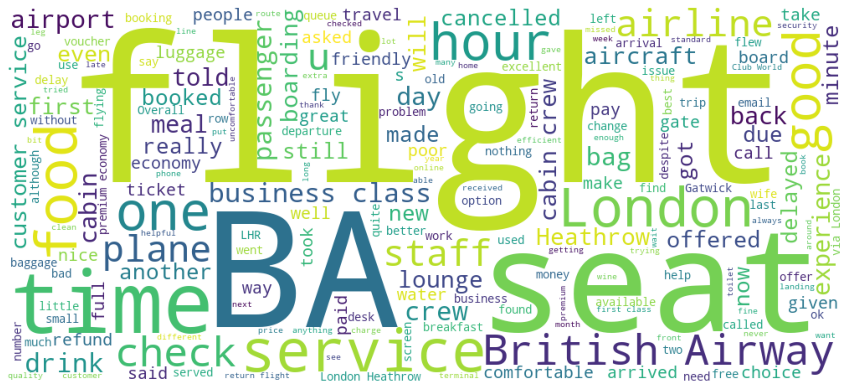

In [22]:
review_word = []

for i in df['reviews'] :
    a = i.split(' ')
    for x in a:
        review_word.append(x)
        
unique_string = (" ").join(review_word)

wc = WordCloud(width = 1000, height = 450, background_color = 'white').generate(unique_string)
plt.figure(figsize=(15,8))
plt.imshow(wc)
plt.axis("off")
plt.show()

From the wordcloud above, we can see the key of topics in customer review are flight, Seat , service and time. showing that 

people are actively talking about their experience on the plane and the staff.



Satisfaction of customer


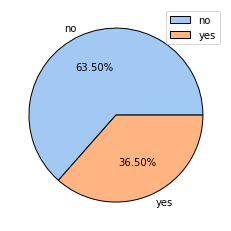

In [28]:
cust_sat = df.groupby('Recommended')['reviews'].count().reset_index()
plt.pie(soc['reviews'], labels = soc['Recommended'], autopct='%.2f%%',colors = sns.color_palette('pastel'),
          wedgeprops={"edgecolor":"k"},)
plt.legend()
plt.show()


From the pie chart above, we know that 63.5% of passengers are dissatisfied with British Airways services. let's breakdown the 

data to found what make passengers dissatisfied :


View rating of BA service by passenger that dissatisfied with British Airways

In [29]:
df_cust = df[df['Recommended'] == 'no']
df_soc.describe()

,Seat Comfort,Cabin Staff Service,Ground Service,Value For Money,Food & Beverages,Inflight Entertainment,Wifi & Connectivity
count,559.000000,551.000000,582.000000,635.000000,458.000000,313.000000,142.000000
mean,2.094812,2.428312,1.948454,1.612598,1.866812,2.130990,1.563380
std,1.072610,1.334111,1.218372,0.890450,1.063494,1.205794,1.048232
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,2.000000,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000
75%,3.000000,3.000000,3.000000,2.000000,3.000000,3.000000,2.000000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


Analysis food on airways

In [30]:
data = df_cust[df_cust['reviews'].str.contains('food | drink')]
data['reviews'].to_csv('test.csv')

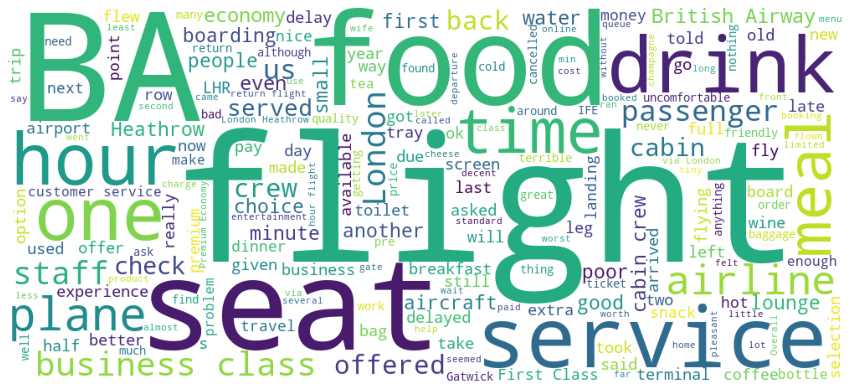

In [31]:
review_word = []

for i in data['reviews'] :
    a = i.split(' ')
    for x in a:
        review_word.append(x)
        
unique_string = (" ").join(review_word)

wc = WordCloud(width = 1000, height = 450, background_color = 'white').generate(unique_string)
plt.figure(figsize=(15,8))
plt.imshow(wc)
plt.axis("off")
plt.show()

In [ ]:
The analyse reveled that :

1. Time to deliver the order is too long
2. The seat, food and drink are quick uncomfortable
3. Minimal selection of food items for purchase.

In [ ]:

Analysis value for money


In [32]:
data = df_cust[df_cust['reviews'].str.contains('money | refund & value')]
data['reviews'].to_csv('test2.csv')

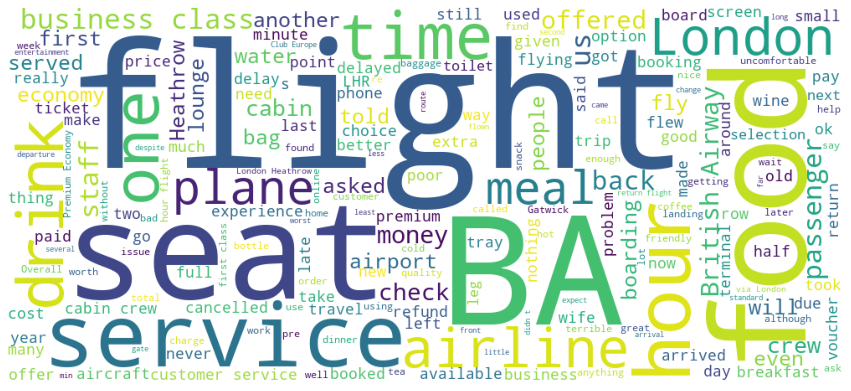

In [33]:

for i in data['reviews'] :
    a = i.split(' ')
    for x in a:
        review_word.append(x)
        
unique_string = (" ").join(review_word)

wc = WordCloud(width = 1000, height = 450, background_color = 'white').generate(unique_string)
plt.figure(figsize=(15,8))
plt.imshow(wc)
plt.axis("off")
plt.show()

In [ ]:
The analysis shown that:

1. Customers are not quick happy with refund turn around time, Long delay time if you are eligible
2. Mandatory use of vouchers and the vouchers are not working as expected
3. Some customers had to pay for drinks and there is no entertainment for 4 hours flight 



# 2. Predictive model - customer bookings


Exploratory data analysis to understand what the dataset have and the statistical properties of the dataset.

In [92]:
import pandas as pd

In [273]:
df = pd.read_csv("customer_booking.csv", encoding="ISO-8859-1")
df.head()

#The .head() method allows us to view the first 5 rows in the dataset, this is useful for visual inspection of our columns

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


In [274]:
df.info()

#The .info() method describe the Data by telling the names of the columns, their data types and how many null values we have. Fortunately, we have no null values. It looks like some of these columns should be converted into different data types, e.g. flight_day.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

To provide more context, below is a more detailed data description, explaining exactly what each column means:

num_passengers = number of passengers
sales_channel = sales channel/booking channel
trip_type = trip Type (Round Trip, One Way, Circle Trip)
purchase_lead = number of days between travel date and booking date
length_of_stay = number of days spent at destination
flight_hour = Hour of flight
flight_day = day of week of flight departure
route = origin -> destination flight route
booking_origin = country of booking
wants_extra_baggage =extra baggage  booked
wants_preferred_seat = preferred seat booked
wants_in_flight_meals = if the customer wanted in-flight meals in the booking
flight_duration = total duration of flight (in hours)
booking_complete = flag indicating if the customer completed the booking


In [275]:
df["flight_day"].unique()

array(['Sat', 'Wed', 'Thu', 'Mon', 'Sun', 'Tue', 'Fri'], dtype=object)

In [276]:
mapping = {
    "Mon": 1,
    "Tue": 2,
    "Wed": 3,
    "Thu": 4,
    "Fri": 5,
    "Sat": 6,
    "Sun": 7,
}

df["flight_day"] = df["flight_day"].map(mapping)

In [277]:
df["flight_day"].unique()

array([6, 3, 4, 1, 7, 2, 5], dtype=int64)

In [278]:
df.describe()

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
count,50000.000000,50000.000000,50000.00000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,1.591240,84.940480,23.04456,9.06634,3.814420,0.668780,0.296960,0.427140,7.277561,0.149560
std,1.020165,90.451378,33.88767,5.41266,1.992792,0.470657,0.456923,0.494668,1.496863,0.356643
min,1.000000,0.000000,0.00000,0.00000,1.000000,0.000000,0.000000,0.000000,4.670000,0.000000
25%,1.000000,21.000000,5.00000,5.00000,2.000000,0.000000,0.000000,0.000000,5.620000,0.000000
50%,1.000000,51.000000,17.00000,9.00000,4.000000,1.000000,0.000000,0.000000,7.570000,0.000000
75%,2.000000,115.000000,28.00000,13.00000,5.000000,1.000000,1.000000,1.000000,8.830000,0.000000
max,9.000000,867.000000,778.00000,23.00000,7.000000,1.000000,1.000000,1.000000,9.500000,1.000000


The .describe() method gives a summary of descriptive statistics over the entire dataset (only works for numeric columns). This gives a quick overview of a few things such as the mean, min, max and overall distribution of each column.

From this point, you should continue exploring the dataset with some visualisations and other metrics that you think may be useful. 

Then, you should prepare your dataset for predictive modelling. Finally, you should train your machine learning model, evaluate it with performance metrics and output visualisations for the contributing variables.


# New feature

For customer behavior to have a trip on holiday (weekend), a feature called is_weekend is created. if the flight day is Saturday or Sunday is_weekend value = 1, for another flight day we give it 0

In [279]:
is_weekend = []

for i in range(len(df)):
    if df['flight_day'][i] == 6 or df['flight_day'][i] == 7:
        is_weekend.append(1)
    else:
        is_weekend.append(0)

df['is_weekend'] = is_weekend
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete,is_weekend
0,2,Internet,RoundTrip,262,19,7,6,AKLDEL,New Zealand,1,0,0,5.52,0,1
1,1,Internet,RoundTrip,112,20,3,6,AKLDEL,New Zealand,0,0,0,5.52,0,1
2,2,Internet,RoundTrip,243,22,17,3,AKLDEL,India,1,1,0,5.52,0,0
3,1,Internet,RoundTrip,96,31,4,6,AKLDEL,New Zealand,0,0,1,5.52,0,1
4,2,Internet,RoundTrip,68,22,15,3,AKLDEL,India,1,0,1,5.52,0,0


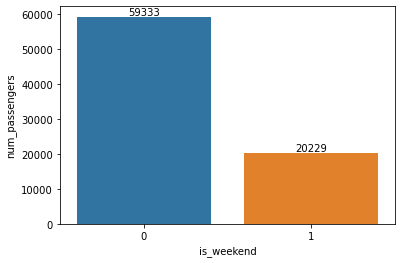

In [280]:
# Analyze data

import matplotlib.pyplot as plt
import seaborn as sns

weekend = df.groupby('is_weekend')['num_passengers'].sum().reset_index()
ax = sns.barplot(data = weekend, x= 'is_weekend', y= 'num_passengers')
ax.bar_label(ax.containers[0])
plt.show()

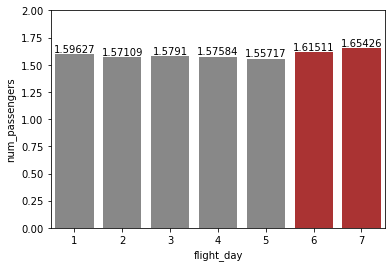

In [281]:
# The average number of passengers per day:

dayperday = df.groupby('flight_day')['num_passengers'].mean().reset_index()

ax = sns.barplot(data = dayperday, x= 'flight_day', y= 'num_passengers')
for bar in ax.patches:
    bar.set_facecolor('#888888')
    
ax.bar_label(ax.containers[0])
plt.ylim(0,2)
ax.patches[5].set_facecolor('#aa3333')
ax.patches[6].set_facecolor('#aa3333')
plt.show()


The above two graphs shown that on weekends the number of passengers is less than on weekdays, but the average number of 

passengers on weekends have a higher value than weekdays, so it is suggested that the number of flights from day to day need to 

be examined. 


In [282]:
df['flight_day'].value_counts().reset_index().sort_values(by='index')

,index,flight_day
0,1,8102
2,2,7673
1,3,7674
3,4,7424
4,5,6761
6,6,5812
5,7,6554


From the table above, weekends have fewer flights comprer to weekdays, so adding flight schedules on weekends is recommended. but to be effective the routes schedules with the most passengers on weekends have to be examined.

In [283]:
route = df[df['is_weekend'] == 1].groupby('route').agg({'num_passengers' : 'sum'}).reset_index().sort_values(by='num_passengers', ascending=False)
route[:5]

,route,num_passengers
4,AKLKUL,1284
243,DMKKIX,462
606,PENTPE,396
375,ICNSIN,311
538,MELSGN,306


The table above revealed the top 5 routes that have the most passengers, so it is recommendedto increase the number of flights to these five routes on weekends.



# Machine Learning Model

Data Preparation
Droping the redundant feature

In [284]:
#Droping columns with many unique values
df['route'].value_counts()

AKLKUL    2680
PENTPE     924
MELSGN     842
ICNSIN     801
DMKKIX     744
          ... 
LBUTPE       1
CXRMEL       1
DELKBR       1
KOSSYD       1
MRUXIY       1
Name: route, Length: 799, dtype: int64

In [189]:

#The route have 799 unique value and that is big, so route column removed

In [285]:
df.drop('route',axis=1, inplace=True)

In [286]:
df['booking_origin'].value_counts()

Australia               17872
Malaysia                 7174
South Korea              4559
Japan                    3885
China                    3387
                        ...  
Panama                      1
Tonga                       1
Tanzania                    1
Bulgaria                    1
Svalbard & Jan Mayen        1
Name: booking_origin, Length: 104, dtype: int64

The booking origin column also has many unique values, not to delete the information from the origin of the booking, the value of the booking origin that contains the name of the country was changed to the name of the continent.

In [287]:
import pycountry_convert as pc
continent = []
index = []

df['booking_origin'] =  df['booking_origin'].replace('Myanmar (Burma)', 'Myanmar')

for i in range(len(df)):
    country = df['booking_origin'][i]
    #print(country)
    try :
        country_code = pc.country_name_to_country_alpha2(country, cn_name_format="default")
        continent_name = pc.country_alpha2_to_continent_code(country_code)
        continent.append(continent_name)
    except:
        continent.append('Others')

df['booking_continent'] = continent


In [288]:
df['booking_continent'].value_counts()

AS        29740
OC        18960
EU          578
NA          525
Others       87
AF           69
SA           41
Name: booking_continent, dtype: int64

In [289]:
#Now we have less unique value to represent booking origin.

df.drop('booking_origin',axis=1, inplace=True)


# Data Cleaning

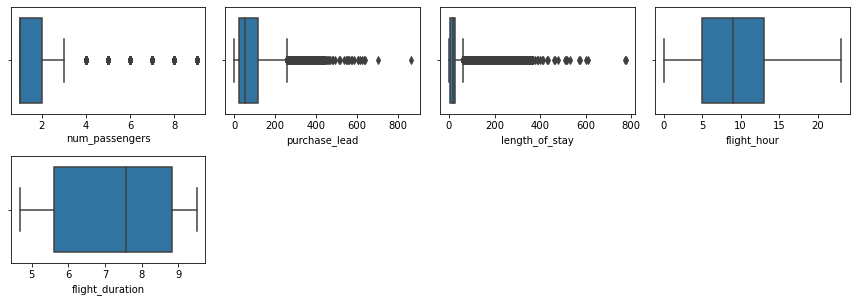

In [290]:
# outlier on numeric column

num = ['num_passengers', 'purchase_lead', 'length_of_stay', 'flight_hour', 'flight_duration']
plt.figure(figsize=(12,8))

for i, column in enumerate (df[num].columns, 1):
    plt.subplot(4,4,i)
    sns.boxplot(data=df[num], x=df[column])
    plt.tight_layout()

The purchase lead and length of stay have a lot of outlier values, so we will delete outlier wtih zscore so that not many columns are wasted

In [291]:
from scipy import stats
import numpy as np

print(f'Total rows before delete outlier : {len(df)}')

filtered_entries = np.array([True] * len(df))

for col in num:
    zscore = abs(stats.zscore(df[col]))
    filtered_entries = (zscore < 3) & filtered_entries
    df = df[filtered_entries]
    
print(f'Total rows after delete outlier : {len(df)}')

Total rows before delete outlier : 50000
Total rows after delete outlier : 47115


C:\Users\sovuehor\AppData\Local\Temp\ipykernel_19920\1639804563.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[filtered_entries]
C:\Users\sovuehor\AppData\Local\Temp\ipykernel_19920\1639804563.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[filtered_entries]
C:\Users\sovuehor\AppData\Local\Temp\ipykernel_19920\1639804563.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[filtered_entries]
C:\Users\sovuehor\AppData\Local\Temp\ipykernel_19920\1639804563.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[filtered_entries]



Transformation

The distribution of numerical data

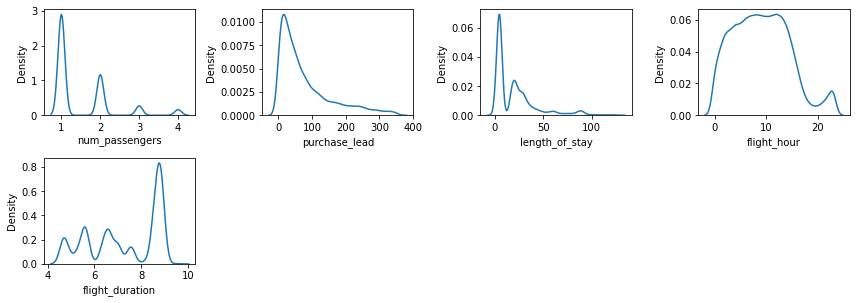

In [292]:
plt.figure(figsize=(12,8))

for i, column in enumerate (df[num].columns, 1):
    plt.subplot(4,4,i)
    sns.kdeplot(data=df[num], x=df[column])
    plt.tight_layout()

It doesn't have a normal distribution,  feature transformation is done to fix it so that the machine learning model has better results

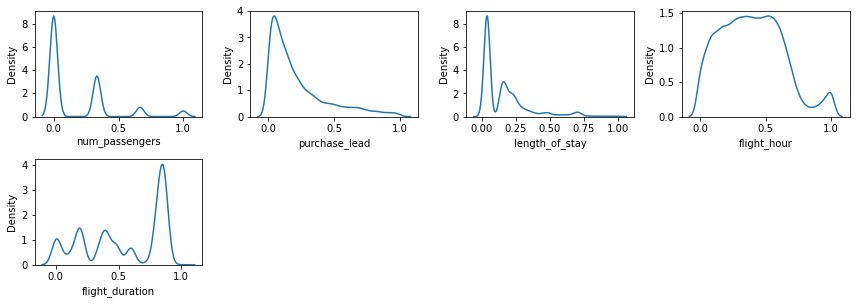

In [293]:
from sklearn.preprocessing import Normalizer

num_max = df[num].max()
num_min = df[num].min()

num_features = (df[num] - num_min) / (num_max - num_min)
num_features.head()

df[num] = num_features

plt.figure(figsize=(12,8))

for i, column in enumerate (df[num].columns, 1):
    plt.subplot(4,4,i)
    sns.kdeplot(data=df, x=df[column])
    plt.tight_layout()

Now the numerical data have a better distribution than before feature transformation.

In [294]:
from sklearn import preprocessing

label_encode = ['sales_channel']
one_hot = ['booking_continent']
                
mapping_trip_type = {
    'RoundTrip'  : 0,
    'OneWay'     : 1,
    'CircleTrip' : 2
}               

df['trip_type'] = df['trip_type'].map(mapping_trip_type)

df['sales_channel'] = preprocessing.LabelEncoder().fit_transform(df['sales_channel'])

onehots = pd.get_dummies(df['booking_continent'], prefix='booking_continent')
df = df.join(onehots)

df.drop('booking_continent', axis=1, inplace=True)

In [295]:
# Split Data

from sklearn.model_selection import train_test_split

x = df.drop(columns=['booking_complete'], axis=1)
y = df['booking_complete']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [ ]:
y_train.value_counts(normalize=True)

In [303]:
#The Data is unbalance, so we need to balancing it with sampling.

from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state = 2)
x_over, y_over = sm.fit_resample(x_train, y_train.ravel())

# Train Machine learning model

In [304]:
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, precision_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

def confusionmatrix(predictions):
    cm = confusion_matrix(y_test, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    return disp.plot()

def eval_classification(model):
    y_pred = model.predict(x_test)
    y_pred_train = model.predict(x_over)
  
    
    print("Accuracy (Test Set): %.2f" % accuracy_score(y_test, y_pred))
    print("Precision (Test Set): %.2f" % precision_score(y_test, y_pred))
    print("Recall (Test Set): %.2f" % recall_score(y_test, y_pred))
    print("F1-Score (Test Set): %.2f" % f1_score(y_test, y_pred))
    
    print("roc_auc (test-proba): %.2f" % roc_auc_score(y_test, y_pred))
    print("roc_auc (train-proba): %.2f" % roc_auc_score(y_over, y_pred_train))

Accuracy (Test Set): 0.85
Precision (Test Set): 0.42
Recall (Test Set): 0.04
F1-Score (Test Set): 0.08
roc_auc (test-proba): 0.52
roc_auc (train-proba): 0.53


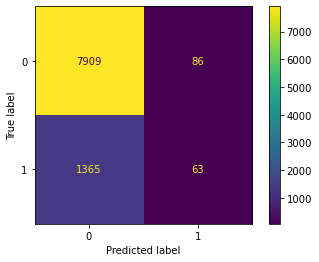

In [311]:
import xgboost as xgb

clf = xgb.XGBClassifier()
clf.fit(x_train, y_train)

predictions = clf.predict(x_test)
confusionmatrix(predictions)
eval_classification(clf)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import numpy as np

#Menjadikan ke dalam bentuk dictionary
hyperparameters = {
                    'max_depth' : [int(x) for x in np.linspace(10, 110, num = 11)],
                    'min_child_weight' : [int(x) for x in np.linspace(1, 20, num = 11)],
                    'gamma' : [float(x) for x in np.linspace(0, 1, num = 11)],
                    'tree_method' : ['auto', 'exact', 'approx', 'hist'],

                    'colsample_bytree' : [float(x) for x in np.linspace(0, 1, num = 11)],
                    'eta' : [float(x) for x in np.linspace(0, 1, num = 100)],

                    'lambda' : [float(x) for x in np.linspace(0, 1, num = 11)],
                    'alpha' : [float(x) for x in np.linspace(0, 1, num = 11)]
                    }

# Init
from xgboost import XGBClassifier
xg = XGBClassifier(random_state=42)
xg_tuned = RandomizedSearchCV(xg, hyperparameters, cv=5, random_state=42, scoring='recall')
xg_tuned.fit(x_over, y_over)

# Predict & Evaluation
eval_classification(xg_tuned)

In [ ]:
predictions = xg_tuned.predict(x_test)
confusionmatrix(predictions)
print(classification_report(y_test, predictions))

Features Importance

<AxesSubplot:>

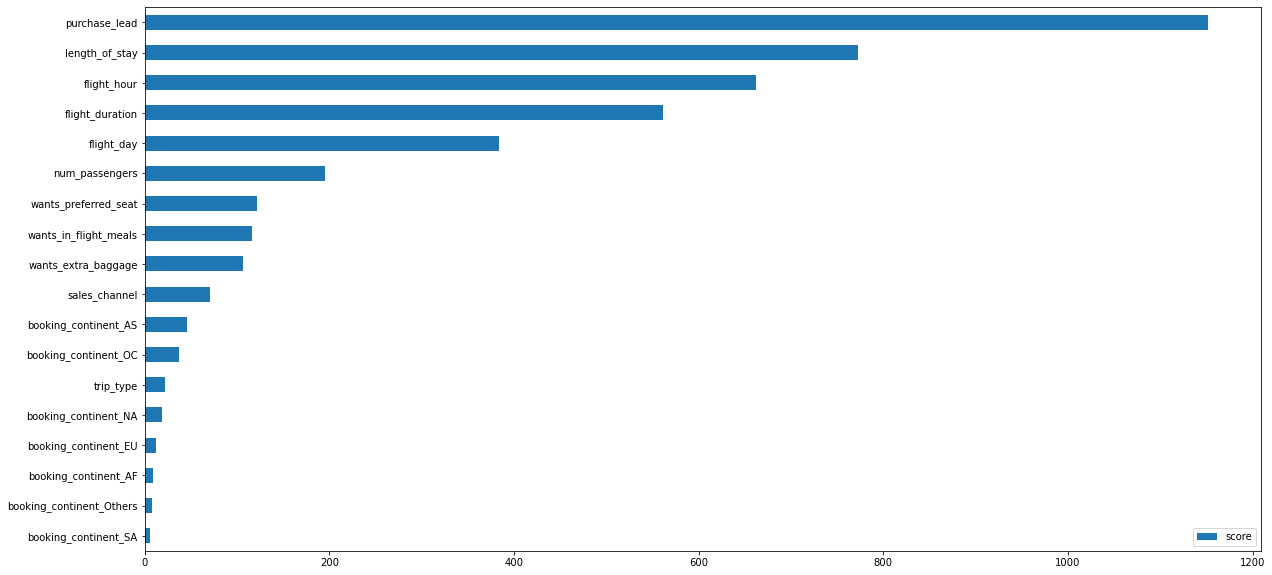

In [319]:
feature_important = clf.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=True)
data.nlargest(40, columns="score").sort_values(by = "score", ascending=True).plot(kind='barh', figsize = (20,10)) ##

The features Importance :

The most important variable in the model was purchase_lead

booking origin and trip type was not important